# Sentiment Analysis of movie review on IMDB Dataset

## Classify movie reviews from IMDB into positive or negative sentiment

### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [27]:
# import libraries

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam

import utils

## Exploring the dataset

In [39]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('Distributional_Semantics/aclImdb_1/train')
test_ds = text_dataset_from_directory('Distributional_Semantics/aclImdb_1/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Show random 5 reviews with length 200 form train dataset**

In [40]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
7515,"Not since Caligula have I considered turning off the movie half-way through....but then with this one, I was only 15 minutes in when I considered. Unfortunately, I did make it all the way through....",0
7788,"This is the worst movie I've ever seen in my life. This is saying quite a bit, considering some of the choices I've made in film rentals.<br /><br />I got this on netflix based entirely on the fac...",0
5887,"I just saw this at the Toronto Film Festival, and I hope it gets wide release because I want to see it again! It is a character-driven film, and Andrew and David are more than up to the task. Any ...",1
3925,It may (or may not) be considered interesting that the only reason I really checked out this movie in the first place was because I wanted to see the performance of the man who beat out Humphrey B...,1
23894,"I remember watching this in the 1970s - then I have just recently borrowed a couple of episodes from our public library.<br /><br />With a nearly 30 year hiatus, I have come to another conclusion....",1


In [41]:
print(dfTrain.loc[0, 'text'])

Once when I was in college and we had an international fair, the Russian section had a Soviet-era poster saying "Ne boltay!", meaning "Don't gossip!". I "translated" it for the "generation" of TV watchers as "Don't be Gladys Kravitz!" (in reference to the nosy neighbor on "Bewitched").<br /><br />However, when you see the result of gossip in the Pvt. Snafu short "Rumors", you see that it's not quite a laughing matter. In this case, the perpetually witless soldier overhears something about bombing and immediately assumes that the Axis Powers have attacked the United States. So, he tells it to someone, who tells someone else, who tells someone else, and it continues. As in "The Russians Are Coming, the Russians Are Coming", the story gets blown more and more out of proportion each time, so that when it gets back to Snafu...well, you know what I mean! Yes, it's mostly WWII propaganda - complete with a derogatory term for the Japanese - but I have to say that the Pvt. Snafu shorts were act

## Tokenize the text

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [45]:
print(train_sequences[0])

[277, 51, 10, 13, 8, 1166, 2, 72, 66, 32, 1957, 1250, 1, 1763, 2419, 66, 3, 3734, 996, 3735, 657, 14896, 52007, 1213, 89, 10086, 10, 5399, 9, 15, 1, 2232, 4, 245, 11037, 14, 89, 27, 14897, 52008, 8, 2888, 5, 1, 16816, 3584, 20, 13886, 7, 7, 187, 51, 22, 64, 1, 956, 4, 10086, 8, 1, 25242, 13420, 343, 9878, 22, 64, 12, 42, 21, 176, 3, 1100, 548, 8, 11, 417, 1, 11585, 9457, 1627, 20598, 139, 41, 9092, 2, 1237, 7916, 12, 1, 17633, 1718, 25, 2974, 1, 2345, 1628, 35, 26, 713, 9, 5, 291, 34, 713, 291, 331, 34, 713, 291, 331, 2, 9, 1992, 14, 8, 1, 8422, 23, 579, 1, 8422, 23, 579, 1, 62, 211, 2640, 50, 2, 50, 43, 4, 11307, 254, 55, 35, 12, 51, 9, 211, 142, 5, 13420, 70, 22, 121, 48, 10, 380, 419, 42, 665, 3008, 2454, 597, 16, 3, 21905, 2876, 15, 1, 857, 18, 10, 25, 5, 132, 12, 1, 25242, 13420, 3146, 68, 162, 176, 160, 4, 261, 234, 33, 66, 881, 9259, 484, 2, 3765, 13887, 3736, 1, 2332, 42, 54, 862, 12, 131, 382, 43, 244, 642, 287, 316]


In [46]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['once', 'when', 'i', 'was', 'in', 'college', 'and', 'we', 'had', 'an', 'international', 'fair', 'the', 'russian', 'section', 'had', 'a', 'soviet', 'era', 'poster', 'saying', 'ne', 'boltay', 'meaning', "don't", 'gossip', 'i', 'translated', 'it', 'for', 'the', 'generation', 'of', 'tv', 'watchers', 'as', "don't", 'be', 'gladys', 'kravitz', 'in', 'reference', 'to', 'the', 'nosy', 'neighbor', 'on', 'bewitched', 'br', 'br', 'however', 'when', 'you', 'see', 'the', 'result', 'of', 'gossip', 'in', 'the', 'pvt', 'snafu', 'short', 'rumors', 'you', 'see', 'that', "it's", 'not', 'quite', 'a', 'laughing', 'matter', 'in', 'this', 'case', 'the', 'perpetually', 'witless', 'soldier', 'overhears', 'something', 'about', 'bombing', 'and', 'immediately', 'assumes', 'that', 'the', 'axis', 'powers', 'have', 'attacked', 'the', 'united', 'states', 'so', 'he', 'tells', 'it', 'to', 'someone', 'who', 'tells', 'someone', 'else', 'who', 'tells', 'someone', 'else', 'and', 'it', 'continues', 'as', 'in', 'the', 'russi

**Get max sequence length of the max length sentence**

In [47]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [48]:
MAX_SEQUENCE_LENGTH

2493

**Add padding in all sequences of sentences those length is less than MAX_SEQUENCE_LENGTH**

In [49]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

**Show second index train_data sequence by replacing 0 with \<PAD\> before train_data sequence**

In [50]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

## Train a classifier with Word Embeddings

In [51]:
countries_wiki = KeyedVectors.load('Distributional_Semantics/wiki-countries.w2v')

In [52]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [53]:
countries_wiki_model = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30
391/391 [==============================] - 4s 9ms/step - loss: 0.6175 - accuracy: 0.6656 - val_loss: 0.5839 - val_accuracy: 0.7010
Epoch 2/30
391/391 [==============================] - 3s 9ms/step - loss: 0.5568 - accuracy: 0.7183 - val_loss: 0.5568 - val_accuracy: 0.7171
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5408 - accuracy: 0.7288 - val_loss: 0.5812 - val_accuracy: 0.7029
Epoch 4/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5298 - accuracy: 0.7373 - val_loss: 0.5383 - val_accuracy: 0.7330
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5214 - accuracy: 0.7424 - val_loss: 0.5460 - val_accuracy: 0.7282
Epoch 6/30
391/391 [==============================] - 4s 10ms/step - loss: 0.5190 - accuracy: 0.7438 - val_loss: 0.5328 - val_accuracy: 0.7368
Epoch 7/30
391/391 [==============================] - 3s 9ms/step - loss: 0.5140 - accuracy: 0.7474 - val_loss: 0.5351 - val_accuracy: 0.7347
Ep

## Train with a different set of word embeddings

### GloVe: Global Vectores for Word Representation

#### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [54]:
glove_wiki = KeyedVectors.load_word2vec_format('data/glove.6B/glove.6B.300d.txt', binary=False, no_header=True)

In [55]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [56]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)

Epoch 1/30
782/782 [==============================] - 9s 12ms/step - loss: 0.5440 - accuracy: 0.7332 - val_loss: 0.4875 - val_accuracy: 0.7910
Epoch 2/30
782/782 [==============================] - 9s 11ms/step - loss: 0.4353 - accuracy: 0.8102 - val_loss: 0.4244 - val_accuracy: 0.8264
Epoch 3/30
782/782 [==============================] - 9s 11ms/step - loss: 0.4088 - accuracy: 0.8232 - val_loss: 0.4174 - val_accuracy: 0.8149
Epoch 4/30
782/782 [==============================] - 9s 11ms/step - loss: 0.3906 - accuracy: 0.8278 - val_loss: 0.3948 - val_accuracy: 0.8275
Epoch 5/30
782/782 [==============================] - 9s 12ms/step - loss: 0.3866 - accuracy: 0.8287 - val_loss: 0.3809 - val_accuracy: 0.8317
Epoch 6/30
782/782 [==============================] - 9s 12ms/step - loss: 0.3798 - accuracy: 0.8315 - val_loss: 0.3790 - val_accuracy: 0.8344
Epoch 7/30
782/782 [==============================] - 9s 11ms/step - loss: 0.3770 - accuracy: 0.8348 - val_loss: 0.3907 - val_accuracy: 0.8256

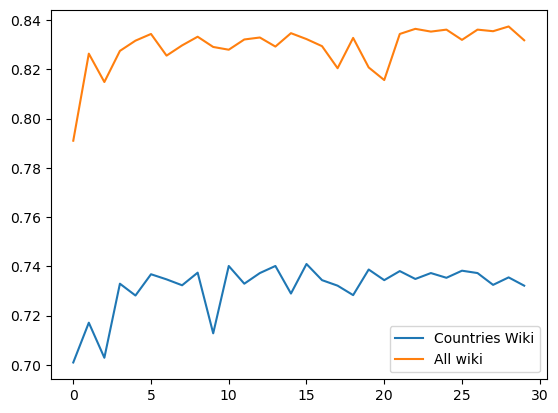

In [57]:
plt.plot(countries_wiki_model.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All wiki')
plt.legend()

## Example input text for prediction

In [78]:
# Example input text for prediction
input_text = ["I wish I knew what to make of a movie like this. It seems to be divided into two parts -- action sequences and personal dramas ashore. It follows Ashton Kutsher through survival swimmer school, guided by Master Chief Kevin Costner, then to Alaska where a couple of spectacular rescues take place, the last resulting in death.<br /><br />I must say that the scenes on the beach struck me as so stereotypical in so many ways that they should be barnacle encrusted. A typical bar room fight between Navy guys and Coast Guardsmen (\"puddle pirates\"). The experienced old timer Costner who is, as an elderly bar tender tells him, \"married to the Coast Guard.\" The older chief who \"keeps trying to prove to himself that he's still nineteen.\" The neglected ex wife ashore to whom Kostner pays a farewell visit. The seemingly sadistic demands placed on the swimmers by the instructors, all in pursuit of a loftier goal. The gifted young man hobbled by a troubled past.<br /><br />The problem is that we've seen it all before. If it's Kevin Costner here, it's Clint Eastwood or John Wayne or Lou Gosset Jr. or Vigo Mortenson or Robert DeNiro elsewhere. And the climactic scene has elements drawn shamelessly from \"The Perfect Storm\" and \"Dead Calm.\" None of it is fresh and none of the old stereotyped characters and situations are handled with any originality.<br /><br />It works best as a kind of documentary of what goes on in the swimmer's school and what could happen afterward and even that\'s a little weak because we don\'t get much in the way of instruction. It\'s mostly personal conflict, romance, and tension about washing out.<br /><br />It\'s a shame because the U. S. Coast Guard is rather a noble outfit, its official mission being \"the safety of lives and property at sea.\" In war time it is transferred to the Navy Department and serves in combat roles. In World War II, the Coast Guard even managed to have a Medal of Honor winner in its ranks.<br /><br />But, again, we don\'t learn much about that. We don\'t really learn much about anything. The film devolves into a succession of visual displays and not too much else. A disappointment."]

# Tokenize the input text using the same tokenizer used during training
tokenized_input = tokenizer.texts_to_sequences(input_text)

# Ensure the sequences are padded to the correct length (MAX_SEQUENCE_LENGTH)
padded_input = pad_sequences(tokenized_input, maxlen=MAX_SEQUENCE_LENGTH)

In [79]:
# Predict sentiment using the trained model
predictions = glove_model.predict(padded_input)

1/1 [==============================] - 0s 80ms/step


In [80]:
print(predictions)

[[0.35967186]]


In [82]:
predicted_labels = (predictions >= 0.5).astype(int)

# Convert binary labels to sentiment labels
sentiment_labels = ["Positive" if label == 1 else "Negative" for label in predicted_labels.flatten()]

# Print the sentiment labels for the input text
for text, sentiment in zip(input_text, sentiment_labels):
    print(f"Text: {text}\n\nPredicted Sentiment: {sentiment}\n")

Text: I wish I knew what to make of a movie like this. It seems to be divided into two parts -- action sequences and personal dramas ashore. It follows Ashton Kutsher through survival swimmer school, guided by Master Chief Kevin Costner, then to Alaska where a couple of spectacular rescues take place, the last resulting in death.<br /><br />I must say that the scenes on the beach struck me as so stereotypical in so many ways that they should be barnacle encrusted. A typical bar room fight between Navy guys and Coast Guardsmen ("puddle pirates"). The experienced old timer Costner who is, as an elderly bar tender tells him, "married to the Coast Guard." The older chief who "keeps trying to prove to himself that he's still nineteen." The neglected ex wife ashore to whom Kostner pays a farewell visit. The seemingly sadistic demands placed on the swimmers by the instructors, all in pursuit of a loftier goal. The gifted young man hobbled by a troubled past.<br /><br />The problem is that we'

## Conclusion:
 - countries_wiki_model is created using countries data(Word Embedding) of wikipidia and this vector has only coverage of wikipidia contants, so this model is providing training accuracy(78.38% ) and validation accuracy(73.22%). 
 
 - glove_model is created using glove(Word Embedding) and glove vector has been trained on greater datasets, so this model is providing very good training accuracy(84.78%) and validation accuracy(83.18%)  **